In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
from tqdm import tqdm_notebook
import torch

Data preparation

In [ ]:
df = pd.DataFrame(pd.read_csv('data_large/train/train.feature', delimiter=":| ", header=None, engine='python'))
df = df[list(filter(lambda x:x%2==1, df.columns))]
df.columns = np.arange(0, 136)
df.to_csv('data/train/feature.csv', index=False, header=False, sep=',')

df = pd.DataFrame(pd.read_csv('data_large/valid/valid.feature', delimiter=":| ", header=None, engine='python'))
df = df[list(filter(lambda x:x%2==1, df.columns))]
df.columns = np.arange(0, 136)
df.to_csv('data/val/feature.csv', index=False, header=False, sep=',')

Read prepared data

In [74]:
df = pd.read_csv('data/train/feature.csv', header=None)
train_features = df.values
df = pd.read_csv('data/test/feature.csv', header=None)
test_features = df.values
df = pd.read_csv('data/val/feature.csv', header=None)
valid_features = df.values

train_features = (train_features - train_features.mean(axis=0, keepdims=True)) / train_features.std(axis=0, keepdims=True)
valid_features = (valid_features - valid_features.mean(axis=0, keepdims=True)) / valid_features.std(axis=0, keepdims=True)
test_features = (test_features - test_features.mean(axis=0, keepdims=True)) / test_features.std(axis=0, keepdims=True)

df = pd.read_csv('data/train/train.click', header=None, delim_whitespace=True, index_col=0)
train_click = df.values
df = pd.read_csv('data/val/valid.click', header=None, delim_whitespace=True, index_col=0)
valid_click = df.values

df = pd.read_csv('data/train/train.init_list', header=None, delim_whitespace=True, index_col=0)
train_init = df.values.astype(int)
df = pd.read_csv('data/test/test.init_list', header=None, delim_whitespace=True, index_col=0)
test_init = df.values.astype(int)
df = pd.read_csv('data/val/valid.init_list', header=None, delim_whitespace=True, index_col=0)
valid_init = df.values.astype(int)

train_init[train_init < 0] = train_features.shape[0]
valid_init[valid_init < 0] = valid_features.shape[0]
test_init[test_init < 0] = test_features.shape[0]

train_grid, _ = np.meshgrid(np.arange(train_init.shape[1]) + 1, np.arange(train_init.shape[0]))
test_grid, _ = np.meshgrid(np.arange(test_init.shape[1]) + 1, np.arange(test_init.shape[0]))
valid_grid, _ = np.meshgrid(np.arange(valid_init.shape[1]) + 1, np.arange(valid_init.shape[0]))
train_grid = train_grid.astype(np.float64)
valid_grid = valid_grid.astype(np.float64)
test_grid = test_grid.astype(np.float64)

train_click[train_click == 0] = -1
valid_click[valid_click == 0] = -1
train_click[train_click != train_click] = -1
valid_click[valid_click != valid_click] = -1

In [75]:
def bias_func(click, bias, alpha=1, beta=1):
    score = np.zeros_like(bias)
    pos = click > 0
    neg = click < 0
    score[pos] = alpha * click[pos] * bias[pos]
    score[neg] = beta * click[neg] / bias[neg]
    return score

alpha = 1
beta = 1

train_bias = bias_func(train_click, train_grid, alpha, beta)
valid_bias = bias_func(valid_click, valid_grid, alpha, beta)

train_scores = np.zeros(train_features.shape[0] + 1)
train_cnt = np.zeros(train_features.shape[0] + 1)
valid_scores = np.zeros(valid_features.shape[0] + 1)
valid_cnt = np.zeros(valid_features.shape[0] + 1)
test_scores = np.zeros(test_features.shape[0] + 1)

train_scores = np.bincount(train_init.reshape(-1), weights=train_bias.reshape(-1))
idx, cnt = np.unique(train_init, return_counts=True)
train_cnt[idx] = cnt
train_scores[train_cnt > 0] /= train_cnt[train_cnt > 0]
train_scores = np.delete(train_scores, -1)
train_cnt = np.delete(train_cnt, -1)

valid_scores = np.bincount(valid_init.reshape(-1), weights=valid_bias.reshape(-1))
idx, cnt = np.unique(valid_init, return_counts=True)
valid_cnt[idx] = cnt
valid_scores[valid_cnt > 0] /= valid_cnt[valid_cnt > 0]
valid_scores = np.delete(valid_scores, -1)
valid_cnt = np.delete(valid_cnt, -1)

train_scores_avail = train_scores[train_cnt > 0]
train_features_avail = train_features[train_cnt > 0]

valid_scores_avail = valid_scores[valid_cnt > 0]
valid_features_avail = valid_features[valid_cnt > 0]

In [76]:
train_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(train_features_avail).to(dtype=torch.float32),
                                                  torch.from_numpy(train_scores_avail).to(dtype=torch.float32)),
                               batch_size = 20000,
                               shuffle = True)

valid_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(valid_features_avail).to(dtype=torch.float32),
                                                  torch.from_numpy(valid_scores_avail).to(dtype=torch.float32)),
                               batch_size = 20000,
                               shuffle = False)

In [18]:
class SimpleNet(nn.Module):
    def __init__(self, n_feature, n_hidden_unit, n_hidden_layer, activation, dropout):
        super(SimpleNet, self).__init__()
        self.layers = [nn.Linear(n_feature, n_hidden_unit)]
        for i in range(n_hidden_layer - 1):
            self.layers.append(activation())
            self.layers.append(nn.Dropout(dropout))
            self.layers.append(nn.Linear(n_hidden_unit, n_hidden_unit))
        self.layers.append(activation())
        self.layers.append(nn.Dropout(dropout))
        self.layers.append(nn.Linear(n_hidden_unit, 1))
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, feature):
        for module in self.layers:
            feature = module(feature)
        score = feature.squeeze()
        return score

In [83]:
EPOCH = 100
LR = 1e-4
weight_decay = 0.01

model = SimpleNet(train_features.shape[1], 3 * train_features.shape[1], 2, nn.LeakyReLU, 0.4).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
loss_func = nn.MSELoss()
losses_train = np.zeros(EPOCH)
losses_valid = np.zeros(EPOCH)

for epoch in tqdm_notebook(range(EPOCH)):
    model.train()
    for feature, score in train_loader:
        feature = feature.cuda()
        score = score.cuda()
        predict = model(feature)
        loss = loss_func(predict, score)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        losses_train[epoch] += loss.item() * feature.shape[0]
    losses_train[epoch] /= len(train_loader.dataset)
        
    model.eval()
    with torch.no_grad():
        for feature, score in valid_loader:
            feature = feature.cuda()
            score = score.cuda()
            predict = model(feature)
            loss = loss_func(predict, score)
            losses_valid[epoch] += loss.item() * feature.shape[0]
        losses_valid[epoch] /= len(valid_loader.dataset)

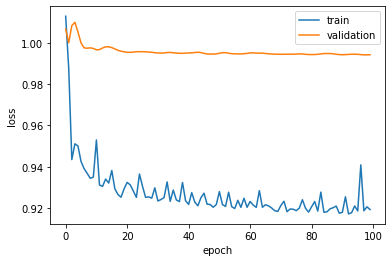

In [84]:
plt.plot(losses_train)
plt.plot(losses_valid)
plt.legend(['train', 'validation'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [125]:
test_loader = data.DataLoader(data.TensorDataset(torch.from_numpy(test_features).to(dtype=torch.float32)), batch_size=20000, shuffle=False)
model.eval()
test_scores = np.array([])
with torch.no_grad():
    for [feature] in test_loader:
        feature = feature.cuda()
        score = model(feature)
        test_scores = np.concatenate([test_scores, score.cpu().numpy()])
test_scores = np.append(test_scores, -np.inf)
test_bias = test_scores[test_init]
test_order = np.take_along_axis(test_init, np.argsort(-test_bias), axis=1)
_, queryId = np.meshgrid(np.arange(test_order.shape[1]), np.arange(test_order.shape[0]))
result = np.vstack((queryId.reshape(-1), test_order.reshape(-1)))
result = np.delete(result, np.argwhere(result[1, :] == test_order.max()), axis=1)
result = result.T
df = pd.DataFrame(result, columns=['QueryId', 'DocumentId'])
df.to_csv('result/0515.csv', index=False)

In [120]:
(test_init != test_init.max()).sum()

18121

In [89]:
with torch.no_grad():
    for feature, score in valid_loader:
        feature = feature.cuda()
        predict = model(feature)
        print(predict.cpu().numpy().max())


0.23373784


2.752284288406372 -1.8168445825576782


In [82]:
(train_click == -1).sum()

49940

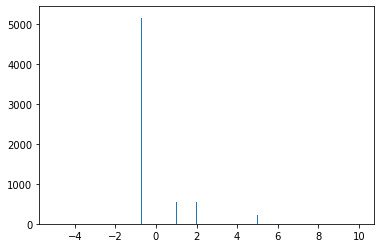

In [43]:
plt.hist(train_bias[train_bias != 0], bins=1000)
plt.show()